# FNN Linus Etemi with Reduced MNIST Data and Max Criteria

## Imports


In [22]:
#Falls NVIDIA GPU vorhanden und CUDA installtion vorhanden: Typ GPU, sonst Typ CPU

TYPE = 'GPU'

if TYPE == 'CPU':
    import numpy as np
else:
    import cupy as np
    
import scipy.special
import math
import matplotlib
import matplotlib.pyplot as matplot
import pickle

from ray import tune
from csv import writer


## Config

In [23]:
#Optimale Parameter durch Gridsearch herausgefunden

outputnodes = 10
hiddennodes = 900
learningrate = 0.05
inputnodes = 784
epochs= 23


## Neuronales Netz 

In [24]:
# Standard FNN aus der Vorlesung

class neuralNetwork:
    def __init__(self, innodes, outnodes, hidnodes, learningrate, epochs):
        self.inodes = innodes
        self.onodes = outnodes
        self.hnodes = hidnodes
        self.lr = learningrate
        self.epo = epochs
        self.wih = ((np.random.rand(self.hnodes,self.inodes)*2)-1)
        self.who = ((np.random.rand(self.onodes,self.hnodes)*2)-1)
        pass
    
    def activation_function(self, z: int) -> classmethod:
        return 1 / (1 + np.exp(-z))

    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)

        final_outputs = self.activation_function(final_inputs)
        
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors) 
        self.who += self.lr * np.dot( (output_errors*final_outputs*(1.0-final_outputs)), np.transpose(hidden_outputs)) 
        self.wih += self.lr * np.dot( (hidden_errors*hidden_outputs*(1.0-hidden_outputs)), np.transpose(inputs)) 
        pass

    def query(self, input_list):
        inputs = np.array(input_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    

    

In [25]:
# Funktion die den Inhalt einer Datei löscht
def clear_content(fname: str) -> None:
    file = open(fname, "w+")
    file.close

## Train_Network

In [26]:
# Funktion zum antrainieren des ersten Netzes
def train_network(n, epo): 
        #öffnen der Train .csv Datei bitte Pfad anpassen
        training_data_file = open("./MNISTData_red/mnist_train_red_8_9_by_90P.csv", 'r')
        training_data_list = training_data_file.readlines()
        training_data_file.close()

        for e in range(epo):
            for record in training_data_list:
                all_values = record.split(',')

                inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
                targets = np.zeros(outputnodes) + 0.01
                targets[int(all_values[0])] = 0.99
                n.train(inputs, targets)

                pass
            pass

## Train_Network 2


In [27]:
#Funktion zum antrainieren des zweiten Netzes
def train_network2(n2, epo, counter):  
        #öffnen der Train .csv Datei die in der testfunktion beschrieben wird, bitte Pfad anpassen
        training_data_file = open('./MNISTData_2nd/mnist_second_train.csv', 'r')
        training_data_list = training_data_file.readlines()
        training_data_file.close()
        for e in range(epo):
            for record in training_data_list:
                all_values = record.split(',')
                inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
                targets = np.zeros(outputnodes) + 0.01
                targets[int(all_values[0])] = 0.99
                n2.train(inputs, targets)
                pass
            pass
        #Das antrainierte Netz wird unter dem Verzeichnis abgespeichert.
        pickle.dump(n2, open('./MNISTNet_2nd/neural_network_'+str(counter)+'.obj', 'wb'))

## Test_Network1 & Train_Network2

In [28]:
#Test des ersten Netzwerks und gleichzeitiges antrainieren des Zweiten
def test_network(n):

    #reduzierter Testdatensatz wird geöffnet
    test_data_file = open("./MNISTData_red/mnist_train_red_8_9_by_90P.csv", 'r')
    test_data_list = test_data_file.readlines()
    test_data_file.close()
    #scorecards
    array_data_all = []
    scorecard_N_plus = []    
    scorecard_N_1R = []
    n2 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)   
    counter = 0

    #2dimensionales array
    for i in range(100):
        array_data_all.append([])
        scorecard_N_plus.append([])
        scorecard_N_1R.append([])

    # für jeden treshold wird das erste netz getestet und die aussortierten daten in eine csv geschrieben 
    for threshold in range(100):
        #Die datei wird nach jedem durchlauf gecleared 
        clear_content('./MNISTData_2nd/mnist_second_train.csv')
        for record in test_data_list:
            all_values = record.rstrip('\n').split(',')
            correct_label = int(all_values[0])
            inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
            outputs = n.query(inputs)
            label_max = outputs[np.argmax(outputs)]
            label = np.argmax(outputs)

            #kriterium
            if(label_max > (threshold/100)):
                scorecard_N_plus[threshold].append(1)
                #überprüfung ob wirklich korrekt
                if(label == correct_label):
                    scorecard_N_1R[threshold].append(1)
                else:
                    scorecard_N_1R[threshold].append(0)
            else:
                scorecard_N_plus[threshold].append(0)
                #die aussortierten werden in die csv geschrieben
                append_list_as_row('./MNISTData_2nd/mnist_second_train.csv', all_values)

        #danach antrainieren des 2ten netzes nach jedem durchlauf
        train_network2(n2, epochs, counter)
        counter += 1


## Gesamttest


In [29]:
def test_network2():
    #öffnen der testdatei
    test_data_file = open("./MNISTData_red/mnist_test_red_8_9_by_90P.csv", 'r')
    test_data_list = test_data_file.readlines()
    test_data_file.close()

    #laden des abgespeicherten ersten netzes
    n1 = pickle.load(open('./MNISTNet_1st/neural_network_1.obj', 'rb'))

    #Listen zum speichern der werte
    P = []
    Q = []
    X = []

    #anzahl der reduzierten Testdaten zum berechnen von X
    Ngesamt = 8215

    #testen der Netze für jeden Treshold von 0 - 1 in 0.01 schritten
    for threshold in range (0,100):
        #iteriert durch alle antrainierten 2ten netze durch
        n2 = pickle.load(open('./MNISTNet_2nd/neural_network_'+str(threshold)+'.obj', 'rb'))
        N_plus = []
        N_1R= []
        N_2R = []

        for record in test_data_list:
            all_values = record.split(',')
            correct_label = int(all_values[0])
            inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01

            outputs_n1 = n1.query(inputs)
            label_n1 = np.argmax(outputs_n1)
            label_n1_max = outputs_n1[np.argmax(outputs_n1)]

            #max kriterium 1tes netz
            if(label_n1_max > (threshold/100)):
                N_plus.append(1)
                if(label_n1 == correct_label):
                    N_1R.append(1)
                    
            else:
                outputs_n2 = n2.query(inputs)
                label_n2 = np.argmax(outputs_n2)

                #überprüfung mit dem 2ten netz ob es richtig ist
                if(label_n2 == correct_label):
                    N_2R.append(1)


        #Listen werden mit den ausgerechneten Werten befüllt, für alle Treshold werte von 0 - 100  
        P.append(len(N_plus)/Ngesamt)
        Q.append(len(N_1R)/len(N_plus))
        X.append((len(N_1R)+len(N_2R))/Ngesamt)

    return P, Q, X

## CSV Writer und Grid Search

In [30]:
# Funktion zum schreiben in eine csv datei, wurde fürs gridsearchen benutzt
def append_list_as_row(fname,list_of_elem):
    with open(fname, 'a+', newline='') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(list_of_elem)

## Scoring und Aufruf von Beiden Netzen

In [31]:
n1 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)
train_network(n1, epochs)

#das antrainierte Netz wird abgespeichert
pickle.dump(n1, open('./MNISTNet_1st/neural_network_1.obj', 'wb'))
#hiermit kann das netz geladen werden, falls es schon antrainiert ist
n1 = pickle.load(open('./MNISTNet_1st/neural_network_1.obj', 'rb'))
test_network(n1)

In [34]:
intermediate_score_card = []
# erstellen des zweiten netzes
n2 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)

P, Q, X = test_network2()
print(P, Q, X)    


[1.0, 1.0, 0.9998782714546561, 0.9996348143639684, 0.9995130858186244, 0.9993913572732805, 0.9987827145465612, 0.9980523432744979, 0.9974437005477784, 0.9970785149117468, 0.9967133292757152, 0.9963481436396835, 0.9961046865489958, 0.9956177723676202, 0.9944004869141814, 0.9933049300060864, 0.9931832014607426, 0.9925745587340231, 0.9917224589166159, 0.9907486305538649, 0.9889227023737066, 0.9881923311016433, 0.9879488740109555, 0.9869750456482045, 0.985514303104078, 0.9846622032866708, 0.9838101034692636, 0.9824710894704808, 0.9818624467437614, 0.9810103469263542, 0.9796713329275715, 0.9789409616555083, 0.9777236762020693, 0.9763846622032867, 0.9755325623858795, 0.9746804625684723, 0.9734631771150335, 0.9722458916615947, 0.9713937918441875, 0.9702982349360925, 0.9684723067559343, 0.967741935483871, 0.9670115642118077, 0.9659160073037127, 0.9648204503956178, 0.9636031649421789, 0.9623858794887401, 0.960438222763238, 0.9592209373097992, 0.9580036518563603, 0.9570298234936092, 0.9560559951

## Plotting

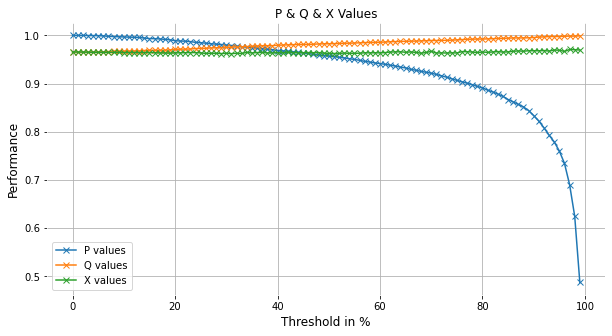

In [35]:
#Erstellen der Grafik
l = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
t_values = []

import numpy as np

N = len(t_values)
l2 = np.arange(N)

with matplot.rc_context({'axes.edgecolor': 'white', 'xtick.color':'black','ytick.color':'black'}):
    matplot.subplots(figsize=(10,5))
    matplot.plot(np.arange(len(P)), P ,marker= 'x', label='P values')
    matplot.plot(np.arange(len(Q)), Q, marker= 'x',label='Q values')
    matplot.plot(np.arange(len(X)), X, marker= 'x',label='X values')

    matplot.grid(True)
    matplot.xlabel("Threshold in %", fontsize = 12, color = 'black')
    matplot.colorbar
    matplot.ylabel("Performance", fontsize = 12, color = 'black')
    matplot.legend()
    matplot.title("P & Q & X Values", fontsize = 12, color = 'black')
    matplot.savefig('diagramm.png')
    matplot.show()


